# 15 - 合成控制

## 一个了解无从知晓事情的超酷数学技巧

当我们审视双重差分法时，我们有来自 2 个不同城市的多个客户的数据：阿雷格里港和弗洛里亚诺波利斯。数据跨越 2 个不同的时间段：在阿雷格里港进行营销干预以增加客户存款之前和之后。为了估计干预效果，我们进行了回归，得到了差异估计量及其标准误差。

对于那种情况，我们有很多样本，因为数据是细颗粒度的。但是，如果我们所拥有的只是城市层面的汇总数据呢？例如，假设我们所拥有的只是干预前后两个城市的平均存款水平。

|城市|之前|之后|
|--|--|--|
|佛罗里达|171.64|206.16|
|POA|46.01|87.06|

我们仍然可以计算 Diff-in-Diff 估计量

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0] ) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

但是请注意，这里的样本量是 4，这也是我们 Diff-in-Diff 模型中的参数数量。在这种情况下，标准误差没有有效地定义，那么我们应该怎么做呢？另一个问题是弗洛里亚诺波利斯可能不像我们希望的那样与阿雷格里港相似。例如，弗洛里亚诺波利斯以其美丽的海滩和随和的人而闻名，而阿雷格里港则以其烧烤和草原而闻名。这里的问题是您永远无法确定您是否使用了适当的对照组。

为了解决这个问题，我们将使用合成控制法，该方法被称为[**“过去几年政策评估文献中最重要的创新”**]（https://www.aeaweb.org/articles?id=10.1257 /jep.31.2.3)。它基于一个简单但强大的想法。我们不需要在未处理中样本找到任何与处理非常相似的单个单元。相反，我们可以将自己的组合打造为多个未经处理的单元的组合，从而创建有效的合成控制。合成控制是极其有效和直观的方法，甚至有一篇文章发表在 [华盛顿邮报](https://www.washingtonpost.com/news/wonk/wp/2015/10/ 30/如何在竞争性声明的世界中衡量事物/），而不是科学期刊上。

In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

要查看它的实际应用，可以考虑估计卷烟税对其消费的影响的问题。为了提供一些背景信息，这是一个在经济学中已经争论了很长时间的问题。论点的一方面说税收将增加雪茄的成本，从而降低其需求。另一方认为，由于香烟会导致成瘾，因此价格的变化不会对他们的需求产生太大影响。在经济方面，我们会说卷烟的需求对价格没有弹性，增加税收只是以吸烟者为代价增加政府收入的一种方式。为了解决问题，我们将查看有关此事的一些美国数据。

1988 年，加利福尼亚州通过了著名的烟草税和健康保护法案，该法案被称为 [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99)。 “它的主要作用是对加利福尼亚州内销售的烟草卷烟征收每包 25 美分的州消费税，对雪茄和嚼烟等其他商业烟草产品的零售征收大致相当的消费税。对烟草销售的限制包括禁止在青少年可以进入的公共场所使用香烟自动售货机，以及禁止个人销售单支香烟。该法案产生的收入被指定用于各种环境和保健计划，以及反烟草烟草广告。”

为了评估其效果，我们可以收集来自多个州和多年的卷烟销售数据。在我们的例子中，我们从 39 个州获得了 1970 年到 2000 年的数据。其他州也有类似的烟草控制计划，因此被排除在分析之外。这是我们的数据的样子。

In [18]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


我们将`state`作为州指数，其中加利福尼亚是第 3 位。我们的协变量是`retprice`（卷烟零售价）和`cigsale`（每包卷烟的人均销售额）。 我们感兴趣的结果变量是`cigsale`。 最后，我们有布尔辅助变量来表示加利福尼亚州和干预后时期。 如果我们绘制加州和其他州的卷烟销售量，这就是我们会得到的。

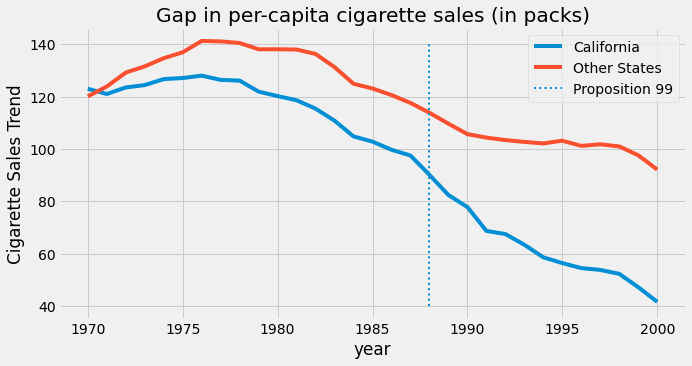

In [19]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

在我们有对应数据的这段时间里，加利福尼亚人的香烟购买量显然低于全国平均水平。此外，80 年代后卷烟消费似乎呈下降趋势。与其他州相比，在 99 号提案之后，加利福尼亚州的下降趋势似乎加速了，但我们不能肯定地说。这只是我们通过审阅绘出的图形得出的猜测。

为了回答 99 号提案是否对卷烟消费产生影响的问题，我们将使用干预前的时期来建立一个综合控制。我们将结合其他州来**建立一个与加州趋势非常相似的假州**。然后，我们将看到这种合成控制在干预后的表现。

## 我们有时间

为了使过程更正式一点，假设我们有 \\(J+1\\) 单位。不失一般性，假设单元 1 是受干预影响的单元。单位 \\(j=2,...,J+1\\) 是未经处理的单位的集合，我们将其称为“供体池”。还假设我们拥有的数据跨越 T 个时间段，在干预之前有 \\(T_0\\) 个时间段。对于每个单元 j 和每个时间 t，我们观察结果 \\(Y_{jt}\\)。对于每个单元 j 和周期 t，将 \\(Y^N_{jt}\\) 定义为没有干预的潜在结果，将 \\(Y^I_{jt}\\) 定义为有干预的潜在结果。然后，对于处理单元 \\(j=1\\) 在时间 t 的影响，对于 \\(t>T_0\\) 定义为

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

由于单位 \\(j=1\\) 是经过处理的单位，因此 \\(Y^I_{jt}\\) 是事实，但 \\(Y^N_{jt}\\) 不是。那么挑战就变成了我们如何估计 \\(Y^N_{jt}\\)。请注意如何为每个时期定义治疗效果，这意味着它可以随时间变化。它不需要是瞬时的。它可以累积或消散。概括地说，估计处理效果的问题归结为**估计如果不进行处理，单元 \\(j=1\\) 的结果会发生什么的问题**。

![img](data/img/synth-control/synth_img.png)

为了估计 \\(Y^N_{jt}\\)，我们记住，供体池中的单位组合可能比单独的任何未处理单位更好地近似处理单位的特征。因此，综合控制被定义为控制池中单元的加权平均值。给定权重 \\(\pmb{W}=(w_2, ..., w_{J+1})\\)，\\(Y^N_{jt}\\) 的综合控制估计为

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

如果所有这些数学运算让您头疼，那么您并不孤单。但别担心，我们有很多例子可以让它更直观。这一次，我喜欢将综合控制视为一种颠倒的回归方式。众所周知，线性回归也是一种将预测作为变量加权平均值的方法。现在，考虑一下那些回归，例如 diff-in-diff 示例中的回归，其中每个变量在一段时间内都是虚拟变量。在这种情况下，回归可以表示为以下矩阵乘法

![img](data/img/synth-control/regr_time.png)

在综合控制案例中，我们没有很多样本，但我们确实有很多时间段。所以我们要做的是翻转输入矩阵。然后，样本成为“变量”，我们将结果表示为样本的加权平均值，就像下面的矩阵乘法一样。

![img](data/img/synth-control/regr_space.png)

如果我们每个时间段有多个特征，我们可以像这样堆积特征。重要的是要做到这一点，以便回归试图通过使用其他单元来“预测”处理过的单元 1。这样，我们可以以某种最佳方式选择权重来实现我们想要的这种接近度。我们甚至可以对特征进行不同的缩放，以赋予它们不同的重要性。

![img](./data/img/synth-control/regr_space_x.png)

那么，如果综合控制可以看作是一个线性回归，那也意味着我们可以用 OLS 来估计它的权重，对吧？对！事实上，让我们现在就这样做。

## 合成控制作为线性回归的一种实现

![img](./data/img/synth-control/allways.png)

为了估计综合控制的治疗效果，我们将尝试构建一个类似于干预期之前的治疗单元的“假单元”。然后，我们将看到这个“假单位”在干预后的表现。合成控制和它所模仿的单位之间的区别在于治疗效果。

要使用线性回归做到这一点，我们将使用 OLS 找到权重。我们将最小化干预前期间供体池中单位的加权平均值与治疗单位之间的平方距离。

为此，我们需要的第一件事是将单位（在我们的例子中为状态）转换为列，将时间转换为行。由于我们有 2 个功能，`cigsale` 和 `retprice`，我们将它们堆叠在一起，就像我们在上图中所做的那样。我们将建立一个在干预前看起来很像加利福尼亚的合成控制，并看看它在干预后的表现如何。出于这个原因，重要的是我们只选择干预前的时期。在这里，这些功能似乎具有相似的规模，因此我们不会对它们做任何事情。如果特征的比例不同，一个是千位，另一个是小数，在最小化差异时，较大的特征将是最重要的。为避免这种情况，首先对它们进行扩展很重要。

In [20]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

现在，我们可以将 Y 变量定义为加利福尼亚州，将 X 定义为其他州。

In [21]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

然后，我们运行回归。 有一个截距相当于添加另一个状态，其中每一行都是 1。你可以这样做，但我认为它更复杂，我就省略了。 回归将返回一组权重，以最小化治疗单位与供体池中单位之间的平方差。

In [22]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

这些权重向我们展示了如何构建合成控制。 我们将状态 1 的结果乘以 -0.436，状态 2 的结果乘以 -1.038，状态 4 的结果乘以 0.679，依此类推。 我们可以通过池中状态的矩阵和权重之间的点积来实现这一点。

In [23]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

现在我们有了合成控制，我们可以用加利福尼亚州的结果变量来绘制它。

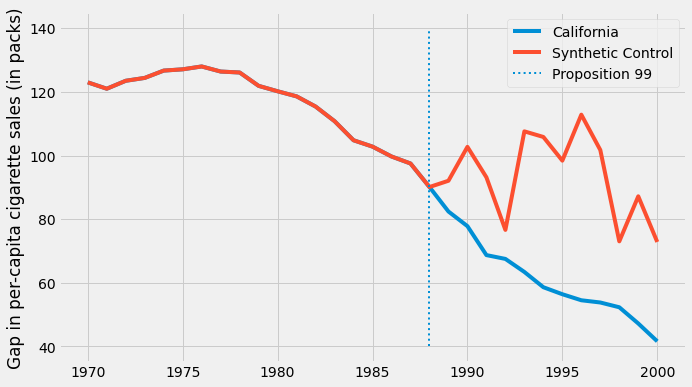

In [24]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

好吧……似乎有些不对劲。这张照片中什么吸引了你的注意力？首先，干预后，合成控制的卷烟销量超过了加州。这表明干预措施成功地降低了卷烟需求。其次，注意干预前的时期是如何完美拟合的。合成控制能够与加利福尼亚州完全匹配。这表明我们的综合控制模型可能过度拟合数据。另一个迹象是干预后综合控制结果变量的巨大差异。注意它是如何不遵循平滑模式的。相反，它会上下波动。

![img](./data/img/synth-control/out-of-sample.png)

如果我们思考为什么会发生这种情况，请记住我们的供体池中有 38 个州。因此，我们的线性回归有 38 个参数可供使用，以使预处理池与处理尽可能接近。在这种情况下，即使 T 很大，N 也很大，这给我们的线性回归模型提供了太多的灵活性。如果您熟悉正则化模型，可以使用 Ridge 或 Lasso 回归来解决此问题。在这里，我们将研究另一种更传统的避免过拟合的方法。

## 不要外推

假设您有下表中的数据，并被要求构建一个合成控制，以使用控制单元的任何线性组合来重现处理过的单元。

|单位|销售额|价格|
|--|--|--|
|控制 1|8|8|
|控制 2|8|4|
|控制 3|4|5|
|处理 |2|10|

由于有 3 个单位和只有 2 个属性要匹配，因此有多个确定性的解决方案可以解决这个问题，但一个不错的解决方案是将第一个控件乘以 2.25，将第二个控件乘以 -2，然后将两者相加。请注意第二次乘法如何创建一个销售量为 -16 且价格为 -8 的假单位。这种乘法将控制 2 单元外推到没有多大意义的数据区域，因为负价格和销售几乎是不可能的。第一个乘法也是外推，因为它将第一个单位带到销售和价格为 18 的地区。这些数字远高于我们数据中的任何数字，因此是外推。

当我们要求它创建合成控制时，这就是回归正在做的事情。外推在技术上并没有错，但在实践中却很危险。我们假设我们从未见过的数据表现得像我们拥有的数据。

一种更安全的方法是将我们的合成控制限制为仅进行插值。为此，我们将权重限制为正且总和为 1。现在，合成控制将是供体池中单元的凸组合。在进行插值时，我们会将处理后的单元投影到由未处理单元定义的凸包中，就像下图一样。

![img](数据/img/synth-control/extrapolation.png)

这里注意两点。首先，在这种情况下，插值将无法创建处理单元的完美匹配。这是因为被处理的是销量最少、价格最高的单位。凸组合只能精确复制控制单元之间的特征。另一件需要注意的是插值是稀疏的。我们将处理过的单元投影到凸包的墙上，而这面墙仅由几个单元定义。出于这个原因，插值将为许多单元分配零权重。

这是一般的想法，现在让我们将其形式化一点。合成控制仍定义为

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

但是现在，我们将使用最小化的权重 \\(\pmb{W}=(w_2, ..., w_{J+1})\\)

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^ {\frac{1}{2}}
$

受限于 \\(w_2, ..., w_{J+1}\\) 为正且总和为 1。请注意，\\(v_h\\) 在最小化处理和合成控制之间的差异时反映了每个变量的重要性。不同的 \\(v\\)s 会给出不同的最佳权重。选择 \\(V\\) 的一种方法是使每个变量都具有均值零和单位方差。一种更复杂的方法是选择 \\(V\\) 以使有助于更好地预测 \\(Y\\) 的变量获得更高的重要性。由于我们希望保持代码简单，我们将简单地为每个变量赋予相同的重要性。

为了实现这一点，首先，定义上述损失函数。

In [25]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

由于我们对每个特征都使用相同的重要性，所以我们不需要担心 \\(v\\)。

现在，为了获得最佳权重，我们将使用 scipy 的二次规划优化。 我们将限制权重总和为 1

```python
lambda x: np.sum(x) - 1
```

此外，我们将优化界限设置在 0 和 1 之间。

In [26]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

有了这个实现，让我们得到定义合成控制的权重

In [27]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000007458


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

有了这个权重，我们将状态 1,2 和 3 乘以零，状态 4 乘以 0.0852 和
很快。 请注意权重是如何稀疏的，正如我们所预测的那样。 此外，所有权重总和为 1，并且介于 0 和 1 之间，满足我们的凸组合约束。

现在，为了获得合成控制，我们可以将这些权重乘以状态，就像我们之前使用回归权重所做的那样。

In [28]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

如果我们现在绘制合成控制的结果，我们会得到一个更平滑的趋势。 另请注意，在干预前期间，合成对照不再精确复制处理过的对象。 这是一个好兆头，因为它表明我们没有过度拟合。

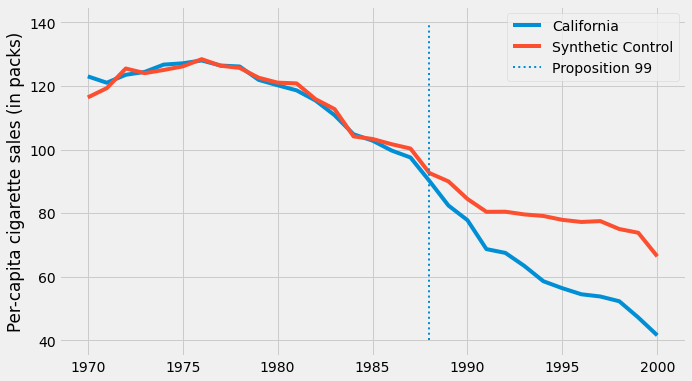

In [29]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

有了手头的合成控制，我们可以将干预效果估计为干预结果与合成控制结果之间的差距。

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

在我们的具体案例中，随着时间的推移，效果会越来越大。

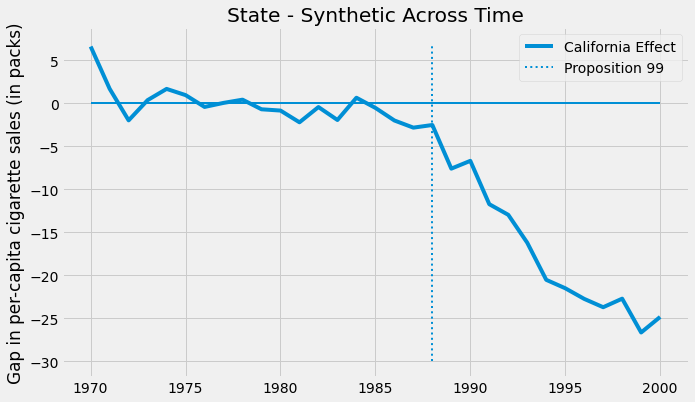

In [30]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

到 2000 年，99 号提案似乎将卷烟销量减少了 25 包。这很酷，但你可能会问自己：我怎么知道这在统计上是否显着？

## 进行推理

由于我们的样本量非常小（39），因此在确定我们的结果是否具有统计学意义时，我们必须更加聪明，而不仅仅是由于随机运气。在这里，我们将使用 Fisher 精确检验的思想。它的直觉非常简单。我们彻底置换处理和控制。由于我们只有一个处理过的单元，这意味着对于每个单元，我们假装它是处理过的，而其他的是对照。

|迭代|1|2|...|39|
|----|-|-|-|-|
|1|处理|0|0|0|
|2|0|处理|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|处理|

最后，我们将为每个状态提供一个合成控制和效果估计。所以它的作用是假装干预实际上发生在另一个州，而不是加利福尼亚，看看这种干预没有发生的估计效果是什么。然后，我们看看加州的干预与其他虚拟干预相比是否足够大。这个想法是，对于实际上没有得到干预的州，一旦我们假装它们是，我们将无法找到任何显著的干预效果。

为了实现这一点，我构建了这个函数，该函数将州作为输入并估计该州的合成控制。此函数返回一个数据框，其中一列用于状态，一列用于年份，一列用于结果“cigsale”和该州的合成结果。

In [31]:
def synthetic_control(state: int, pool: List[int], data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

下面是我们应用该函数到第一个州的结果。

In [32]:
control_pool = cigar["state"].unique()

synthetic_control(1, control_pool, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


为了获得所有州对应的结果，我们在 8 个进程中并行计算。 如果您的计算机有更多或更少的内核，您可以使用不同的数量。 此代码将返回与上面类似的数据帧列表。

In [33]:
from joblib import Parallel, delayed

parallel_fn = delayed(partial(synthetic_control, pool=control_pool, data=cigar))

sinthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [34]:
sinthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


通过对所有州应用合成控制，我们可以估计所有州的合成状态与真实状态之间的差距。 对于加州来说，这就是干预效果。 对于其他州，这就像安慰剂效应，我们在其中估计了干预实际上没有发生的合成对照干预效果。 如果我们将所有安慰剂效应与加利福尼亚治疗效应一起绘制，我们会得到下图。

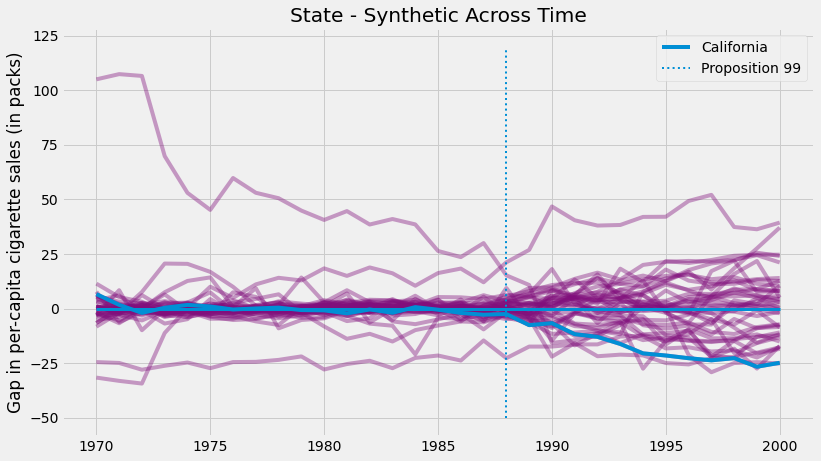

In [35]:
plt.figure(figsize=(12,7))
for state in sinthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

这个数字的两个方面让人眼前一亮。 首先，我们可以看到干预后的方差高于干预前的方差。 这是意料之中的，因为合成控制旨在最大限度地减少干预前期间的差异。 另一个有趣的方面是，即使在干预前的时期，我们也不能很好地拟合一些单位。 这也是意料之中的。 例如，如果某些州的卷烟消费量非常高，那么其他州的凸组合将永远无法匹配它们。

由于这些单位的拟合度很差，因此最好将它们从分析中删除。 客观地做到这一点的一种方法是设置干预前错误的阈值

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

并删除那些具有高错误的单元。 如果我们像这样继续并绘制相同的图形，这就是我们得到的。

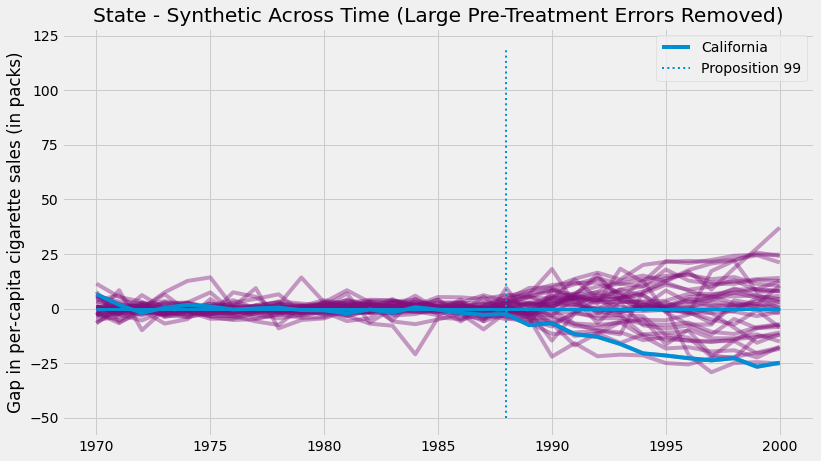

In [36]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in sinthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

去除噪音，我们可以看到加利福尼亚州的值是多么极端。 这张图片告诉我们，如果我们假装这种干预发生在任何其他州，我们几乎永远不会得到像加利福尼亚那样极端的效果。

这张图片本身就是一种推理形式，但我们也可以从这些结果中得出 P 值。 我们所要做的就是看看我们所获得的效果比加利福尼亚的效果低多少倍。

In [37]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in sinthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975492409


array([  5.79715885,   0.89458997, -24.83015975,  -7.16628121,
       -10.92204857,  37.11640557, -15.06971695,  -0.49805108,
       -18.45795062,  21.13366444,  12.57782771,  -1.47547827,
        10.49627353, -11.6701235 ,   4.29850824,   8.04811405,
        14.02322417,   8.25002748,   0.32576356,  -8.40826855,
        -2.12402704,  -7.42865016,   2.9615753 ,  24.10478116,
         4.25211769, -17.75844573,   7.93334016,   2.81640126,
        12.6495596 , -17.47677512, -25.16040937, -12.26469121,
        24.69067369,  10.36299581,  -8.59880336])

如果我们想检验加利福尼亚的效应低于零的单方面假设，我们可以将 P 值估计为加利福尼亚的效应大于所有估计效应的倍数。

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

事实证明，2000 年加州的干预效果是 -24.8，这意味着干预措施减少了近 25 包香烟的消费量。 在我们估计的所有其他 34 种安慰剂效应中，只有一种高于我们在加利福尼亚发现的效应。 所以 p 值为 1/35。

In [38]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

最后，我们可以展示效果的分布，从而让大家感受一下加州的干预效果估计值是多么的极端。

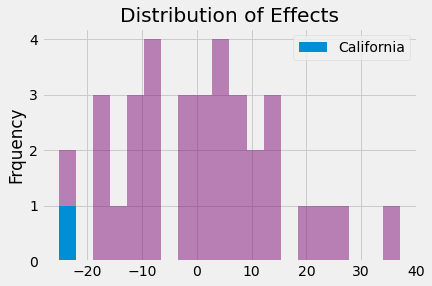

In [39]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

## 关键思想

我们了解到，如果我们只有城市或州等实体的聚合级别数据，diff-in-diff 将不允许我们进行推理。 此外，它还有一些其他限制，因为它必须定义一个控制单元，而一个单独的控制单元可能不能很好地表示处理单元的反事实。

为了纠正这一点，我们了解到我们可以构建一个合成控件，将多个控制单元组合在一起，使它们与处理过的单元相似。 通过这种综合控制，我们能够看到在没有治疗的情况下我们的治疗单元会发生什么。

最后，我们看到了如何使用 Fisher 精确检验通过合成控制进行推理。 也就是说，我们假设未处理的单位实际上是处理过的并计算了它们的效果。 这些是安慰剂效应：即使没有治疗我们也会观察到的效应。 我们使用这些来查看我们估计的治疗效果是否具有统计学意义。